# ORIE 5230 Trading Assignment 1
### Chen Zhong cz379

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing as mp
import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from tiingo import TiingoClient

################### Tiigo setup####################
#tiingo stock pull setup
config = {}
# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True
# If you don't have your API key as an environment variable,
# pass it in via a configuration dictionary.
mykey = 'secretkey'
config['api_key'] = mykey
# Initialize
client = TiingoClient(config)
################### end tiingo stock pull setup ####

### Determine Best Parameters

In [3]:
def ma_strat(tic, l_size, s_size, start, end):
    tic_price = client.get_dataframe(tic, startDate=start, endDate=end)['adjClose']
    df = pd.DataFrame(tic_price)
    df.columns = ['price']
    short = 'p'+str(s_size)
    long = 'p'+str(l_size)
    df[short]=df['price'].rolling(s_size).mean()
    df[long]=df['price'].rolling(l_size).mean()
    df['signal']=(df[short]>df[long])*2-1+df[long].isnull()
    daily_ret = df['price']/df['price'].shift(1)-1
    # short over long
    s_gt_l = (daily_ret[df['signal'].shift(1)>0] + 1).prod() - 1
    # long over short
    l_gt_s = (daily_ret[df['signal'].shift(1)<0] + 1).prod() - 1
    cum = (df['signal'].shift(1)*daily_ret + 1).cumprod() - 1
    plt.plot(cum)
    title_text = "Moving Average Strategy Return: long window = %s, short window = %s" % (l_size, s_size)
    plt.title(title_text)
    return s_gt_l, l_gt_s, cum[-1]
    """
    return:
    1. cumulative return of period when short ma over long ma
    2. cumulative return of period when long ma over short ma
    3. overall strategy cumultiave return
    
    """

In [39]:
tic = 'AAPL'; start = '2000-01-01'; end = '2018-01-01'

tic_price = client.get_dataframe(tic, startDate=start, endDate=end)['adjClose']

def ma_strat_test(price, l_size, s_size):
    df = pd.DataFrame(price)
    df.columns = ['price']
    short = 'p'+str(s_size)
    long = 'p'+str(l_size)
    df[short]=df['price'].rolling(s_size).mean()
    df[long]=df['price'].rolling(l_size).mean()
    df['signal']=(df[short]>df[long])*2-1+df[long].isnull()
    daily_ret = df['price']/df['price'].shift(1)-1
    # short over long
    s_gt_l = (daily_ret[df['signal'].shift(1)>0] + 1).prod() - 1
    # long over short
    l_gt_s = (daily_ret[df['signal'].shift(1)<0] + 1).prod() - 1
    cum = (df['signal'].shift(1)*daily_ret + 1).cumprod() - 1
    return cum[-1], l_size, s_size
    # cumulative returns, long window size, and short windows size
    # output for easy screening

### All combinations within 300 days period
##### Set up multiprocessing

In [40]:
window_comb = {}
window_comb_idx = [[(i, i-j) for j in range(1, i)] for i in range(2, 300)]
window_comb_list = []
for l in window_comb_idx:
    window_comb_list += l
for i in range(len(window_comb_list)):
    window_comb[i] = window_comb_list[i]
n_jobs = min(len(window_comb), mp.cpu_count())

In [41]:
len(window_comb)

44551

In [42]:
n_jobs

8

In [43]:
pool = mp.Pool(processes = n_jobs)

In [44]:
st = time.time()
jobs = {}
for key, argument in window_comb.items():
    job = pool.apply_async(ma_strat_test, args=(tic_price, argument[0], argument[1], ))
    jobs[key] = job
pool.close()
pool.join()
results = {}
for key in window_comb.keys():
    results[key] = jobs[key].get() 
end = time.time()
print(end - st)

132.37993383407593


In [46]:
max(results.values())

(164.82896813535623, 185, 2)

### best parameters are:
##### long window: 185 days
##### short window: 2 days

In [30]:
gen_diff_list = list(results.values())
x = np.array([gen_diff_list[i][1] for i in range(0, len(gen_diff_list), 100)])
y = np.array([gen_diff_list[i][2] for i in range(0, len(gen_diff_list), 100)])
z = np.array([gen_diff_list[i][0] for i in range(0, len(gen_diff_list), 100)])

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


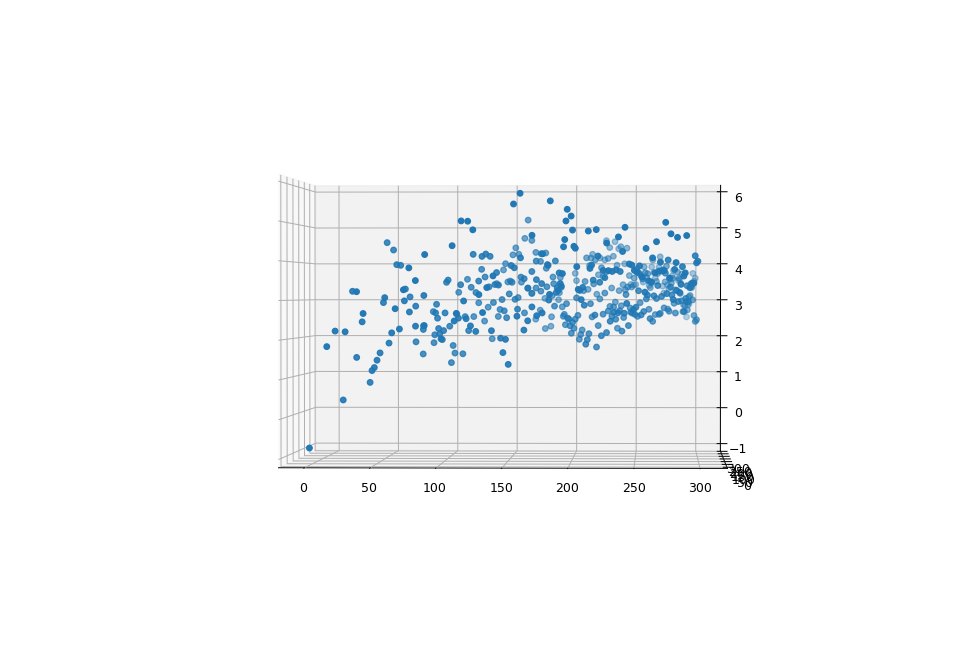

In [37]:
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()

#### For this specific time period (2000 to 2018), smaller small ma window and higher large ma window yields better return 

##### AAPL Returns with long window = 185, short window = 2 yields highest return

(187.47513213867322, -0.7378724029643884, 164.82896813535623)

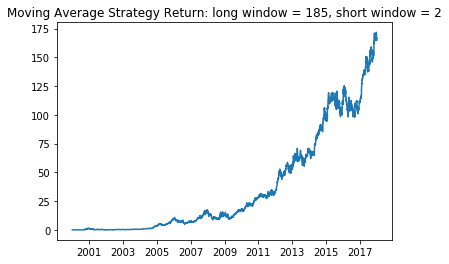

In [56]:
ma_strat('AAPL', 185, 2, '2000-01-01', '2018-01-01')

##### AAPL return with long window = 200, short window = 50, not the best

(43.78384292212028, 1.7451164165411672, 4.818971736820457)

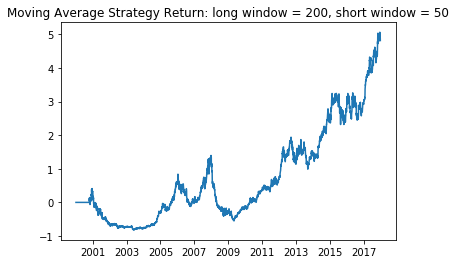

In [57]:
ma_strat('AAPL', 200, 50, '2000-01-01', '2018-01-01')

##### AAPL return with long window = 50, short window = 10, not the best

(25.478537267565915, 0.7474323908428455, 3.4212849676241124)

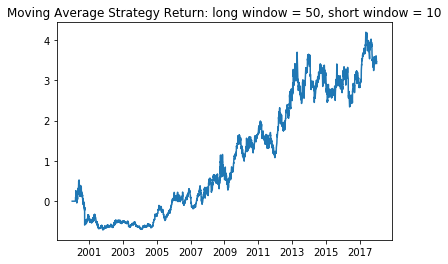

In [58]:
ma_strat('AAPL', 50, 10, '2000-01-01', '2018-01-01')

##### Test strategy with latest data, reasonable return

(0.21597309335490977, 0.02335996126835438, 0.18675944534834832)

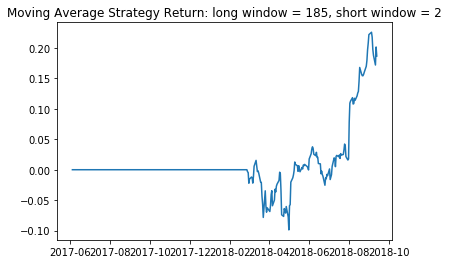

In [5]:
ma_strat('AAPL', 185, 2, '2017-06-02', '2018-09-13')

##### MSFT return with long window = 185, short window = 2, terrible result, meaning the strategy doesn't work across asset

(0.9597067216656352, 1.1410619726141218, -0.6477595541278156)

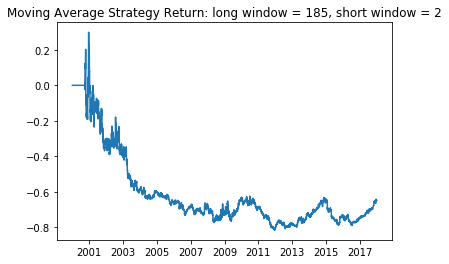

In [59]:
ma_strat('MSFT', 185, 2, '2000-01-01', '2018-01-01')

-------

# Quantopian Backtests
* Code attached
* Tearsheet copied from quantopian notebook json file

In [6]:
"""    
ORIE 5230 Trading Assignment 1

Simple moving average crossover
From research, short MA: 2, long MA: 185
every day, long if SMA 2 is greater than SMA 185, short otherwise
"""

def initialize(context):
    set_benchmark(symbol('SPY'))
    # context.tic = sid(24) # AAPL
    context.tic = sid(5061) # MSFT
    
    #Run algo daily
    schedule_function(ma_crossover, 
                      date_rules.every_day())

def ma_crossover(context, data):
    hist = data.history( 
        context.tic,
        fields= 'price', 
        bar_count=200, 
        frequency='1d'
    )
 
    sma_long = hist[-185:].mean()
    sma_short = hist[-2:].mean()
 
# see all open orders.
    open_orders = get_open_orders()
 
# If no open orders, long all 
#execute scheduled market order if SMA short is greater than SMA long. 
    if sma_short > sma_long:
        if context.tic not in open_orders:
            order_target_percent(context.tic, 1.0)
   
# If no open orders, short all
#execute scheduled market order if SMA long is greater than SMA short. 
    elif sma_long > sma_short: 
        if context.tic not in open_orders:
            order_target_percent(context.tic, -1.0)

### AAPL MA 2-185 crossover from 2002-10-18 to 2018-01-01
* Good return, just as research suggested

100% Time: 0:00:04|###########################################################|


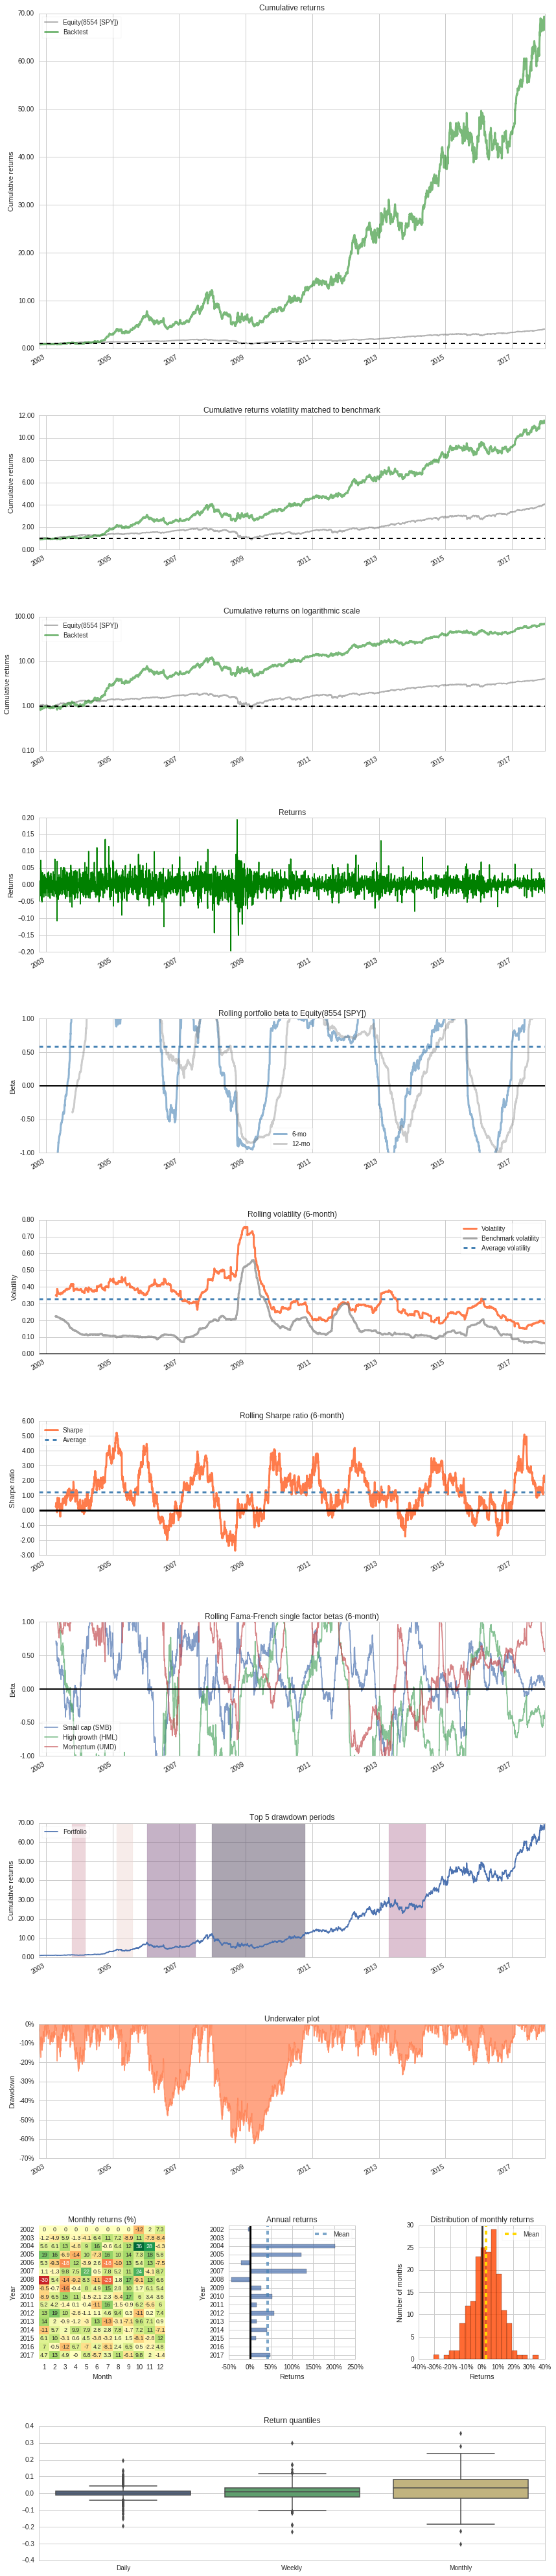

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


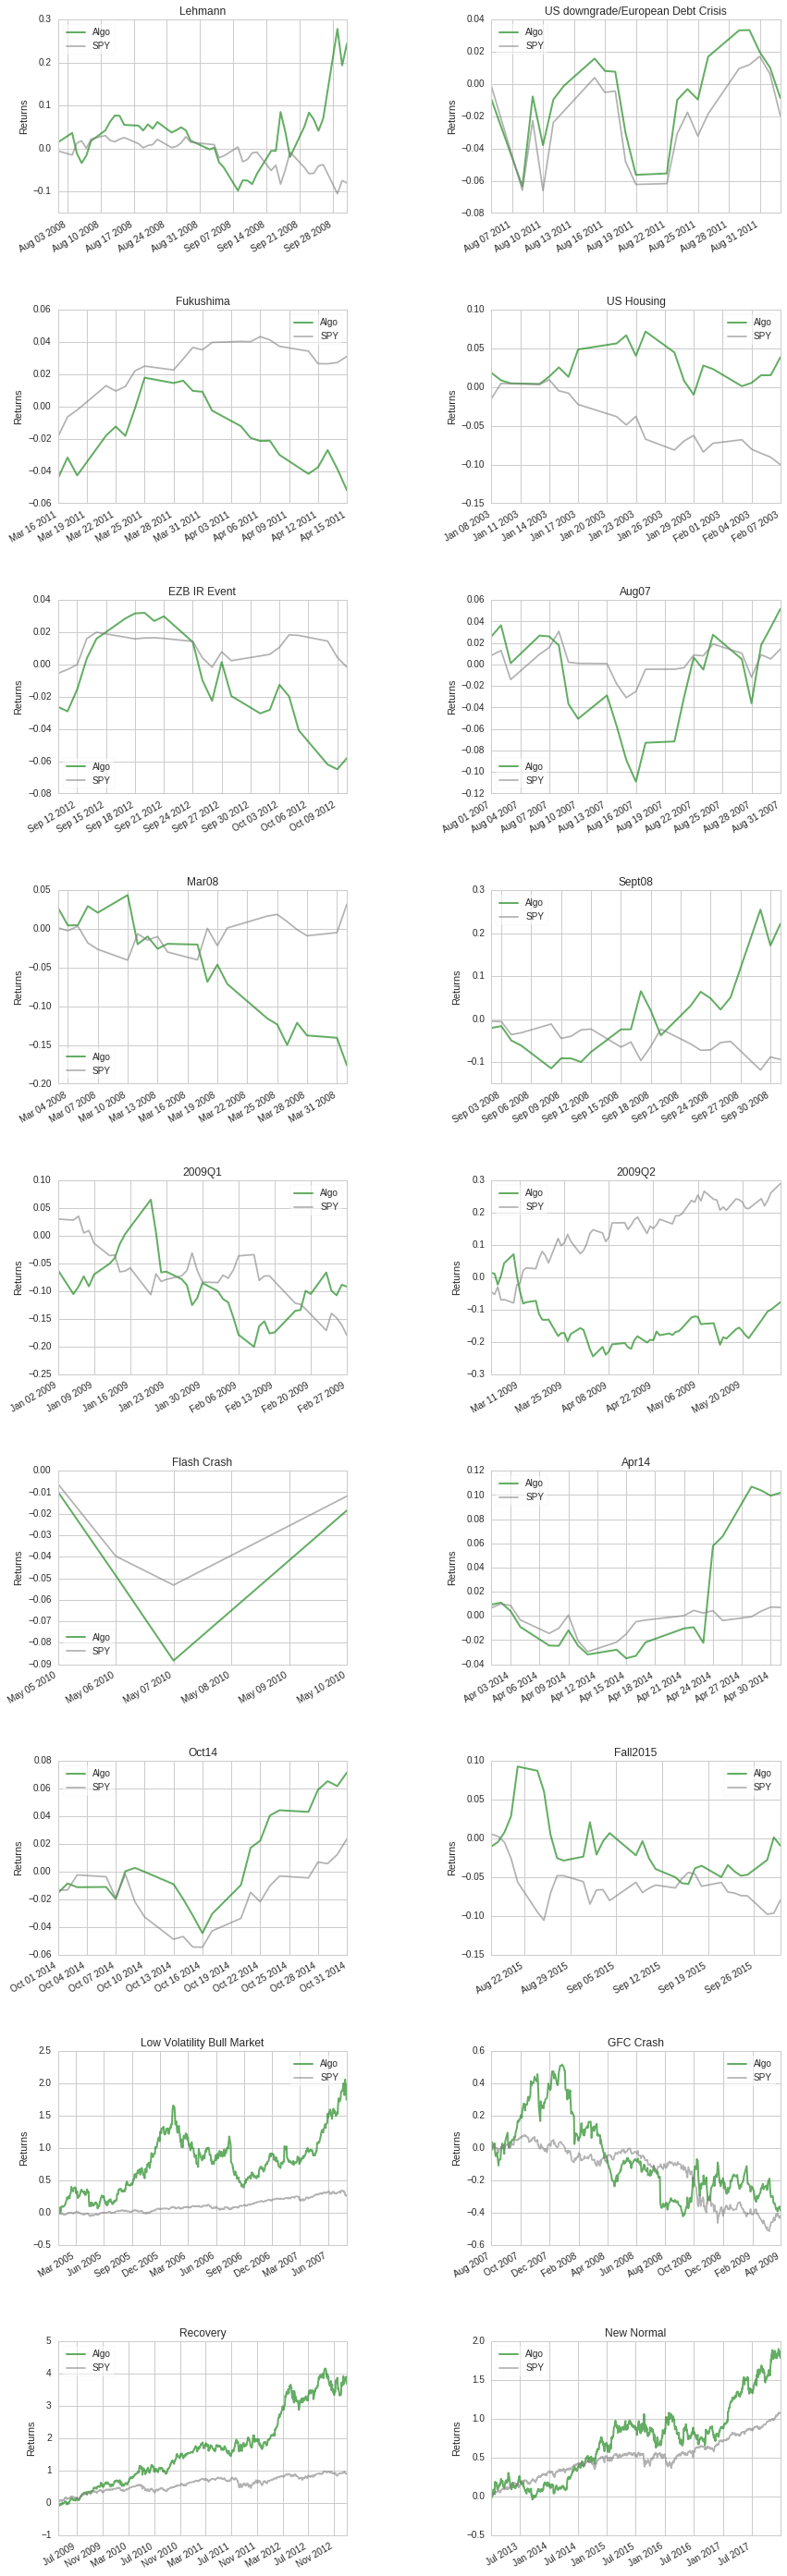

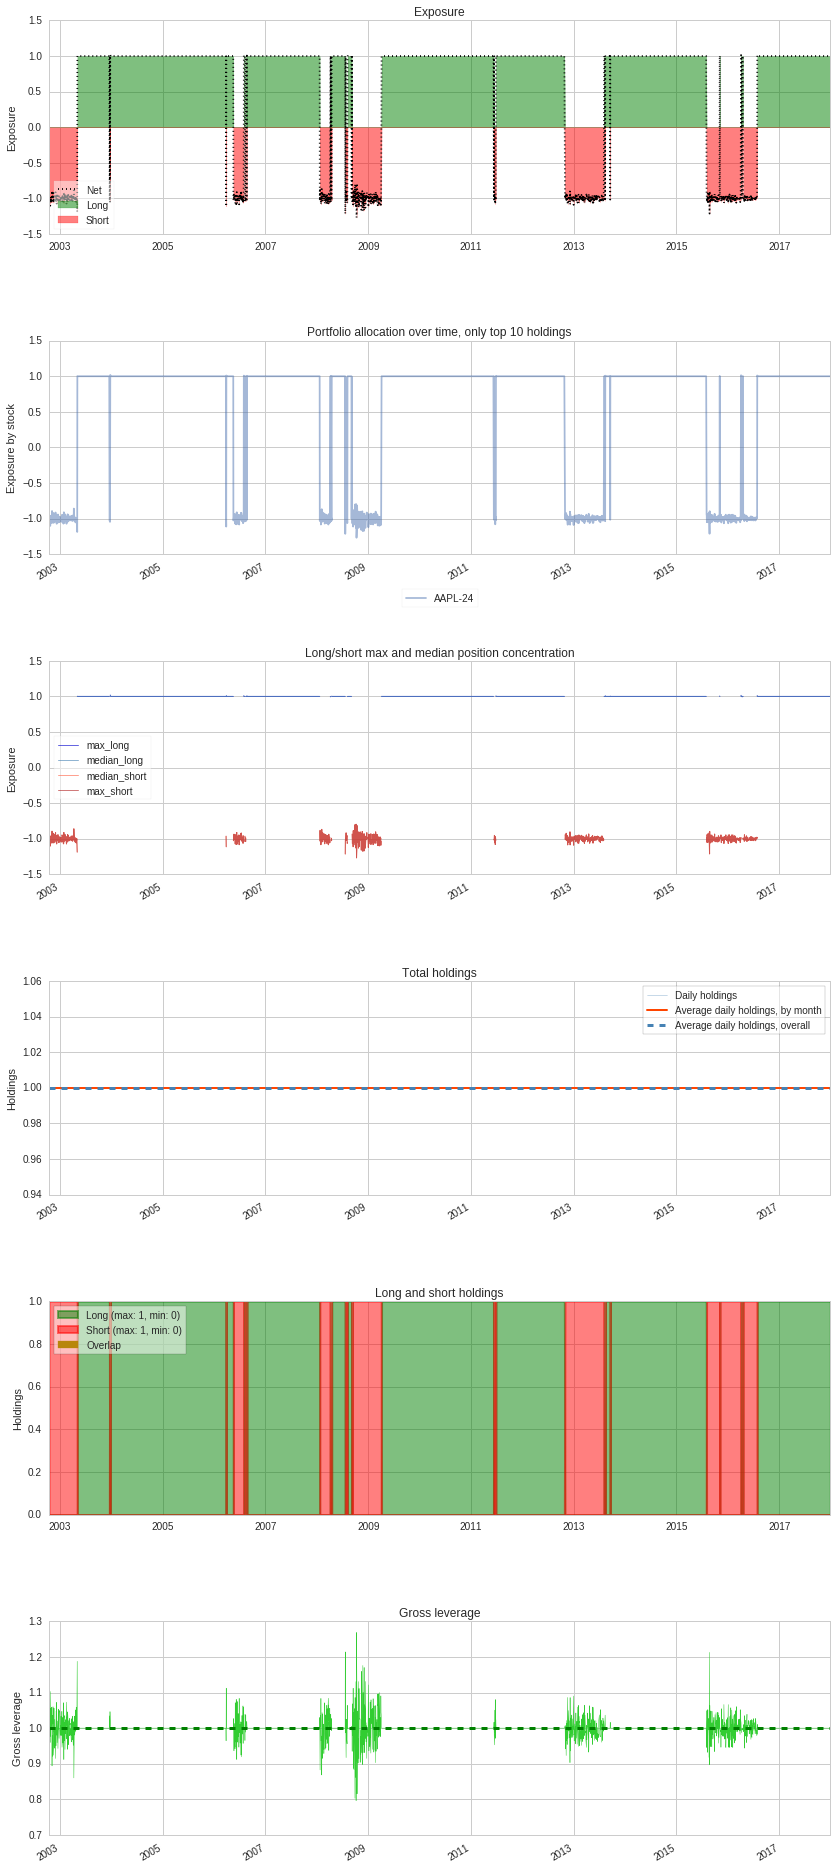

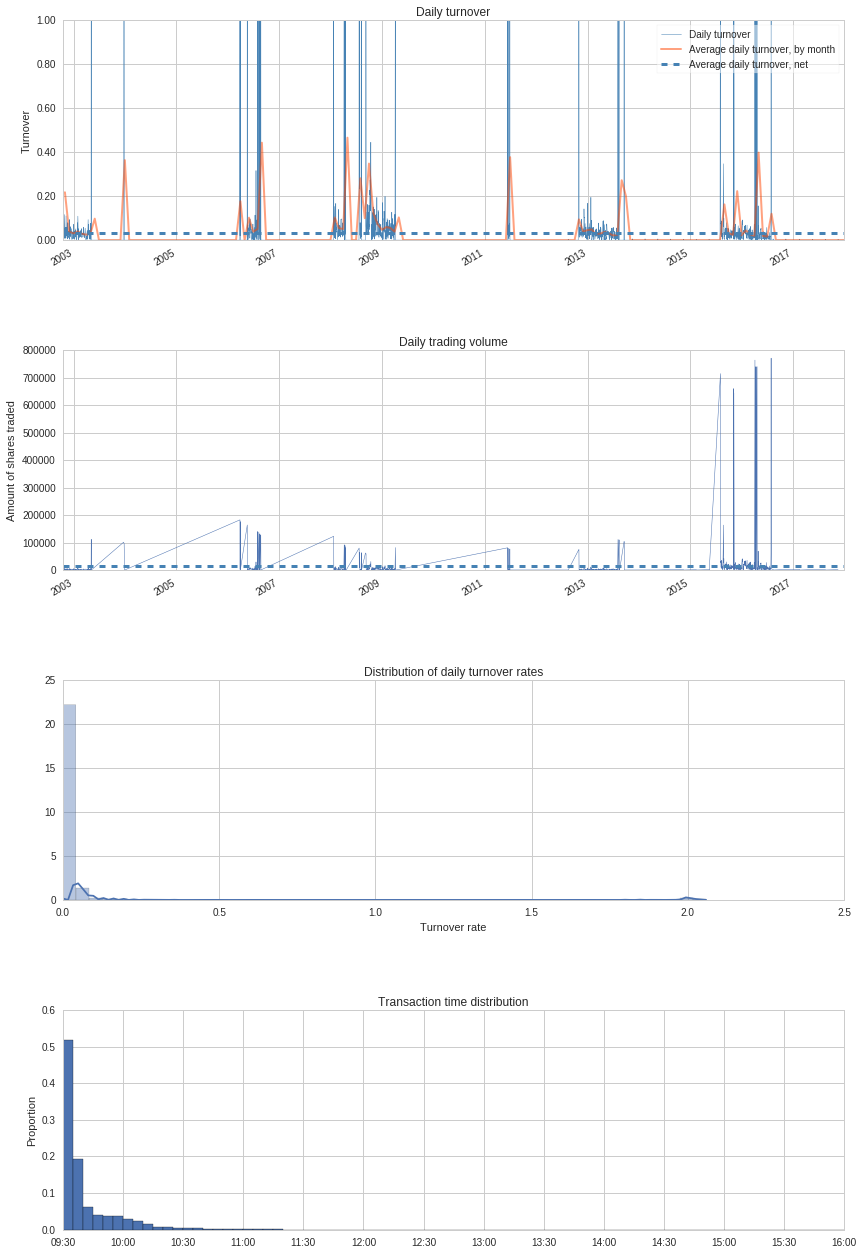

/usr/local/lib/python2.7/dist-packages/pyfolio/perf_attrib.py:589: UserWarning: Could not find factor loadings for 556 dates: (first missing is 2002-10-17 00:00:00+00:00, last missing is 2004-12-31 00:00:00+00:00). Truncating date range for performance attribution. 
  warnings.warn(warning_msg)


## Performance Relative to Common Risk Factors

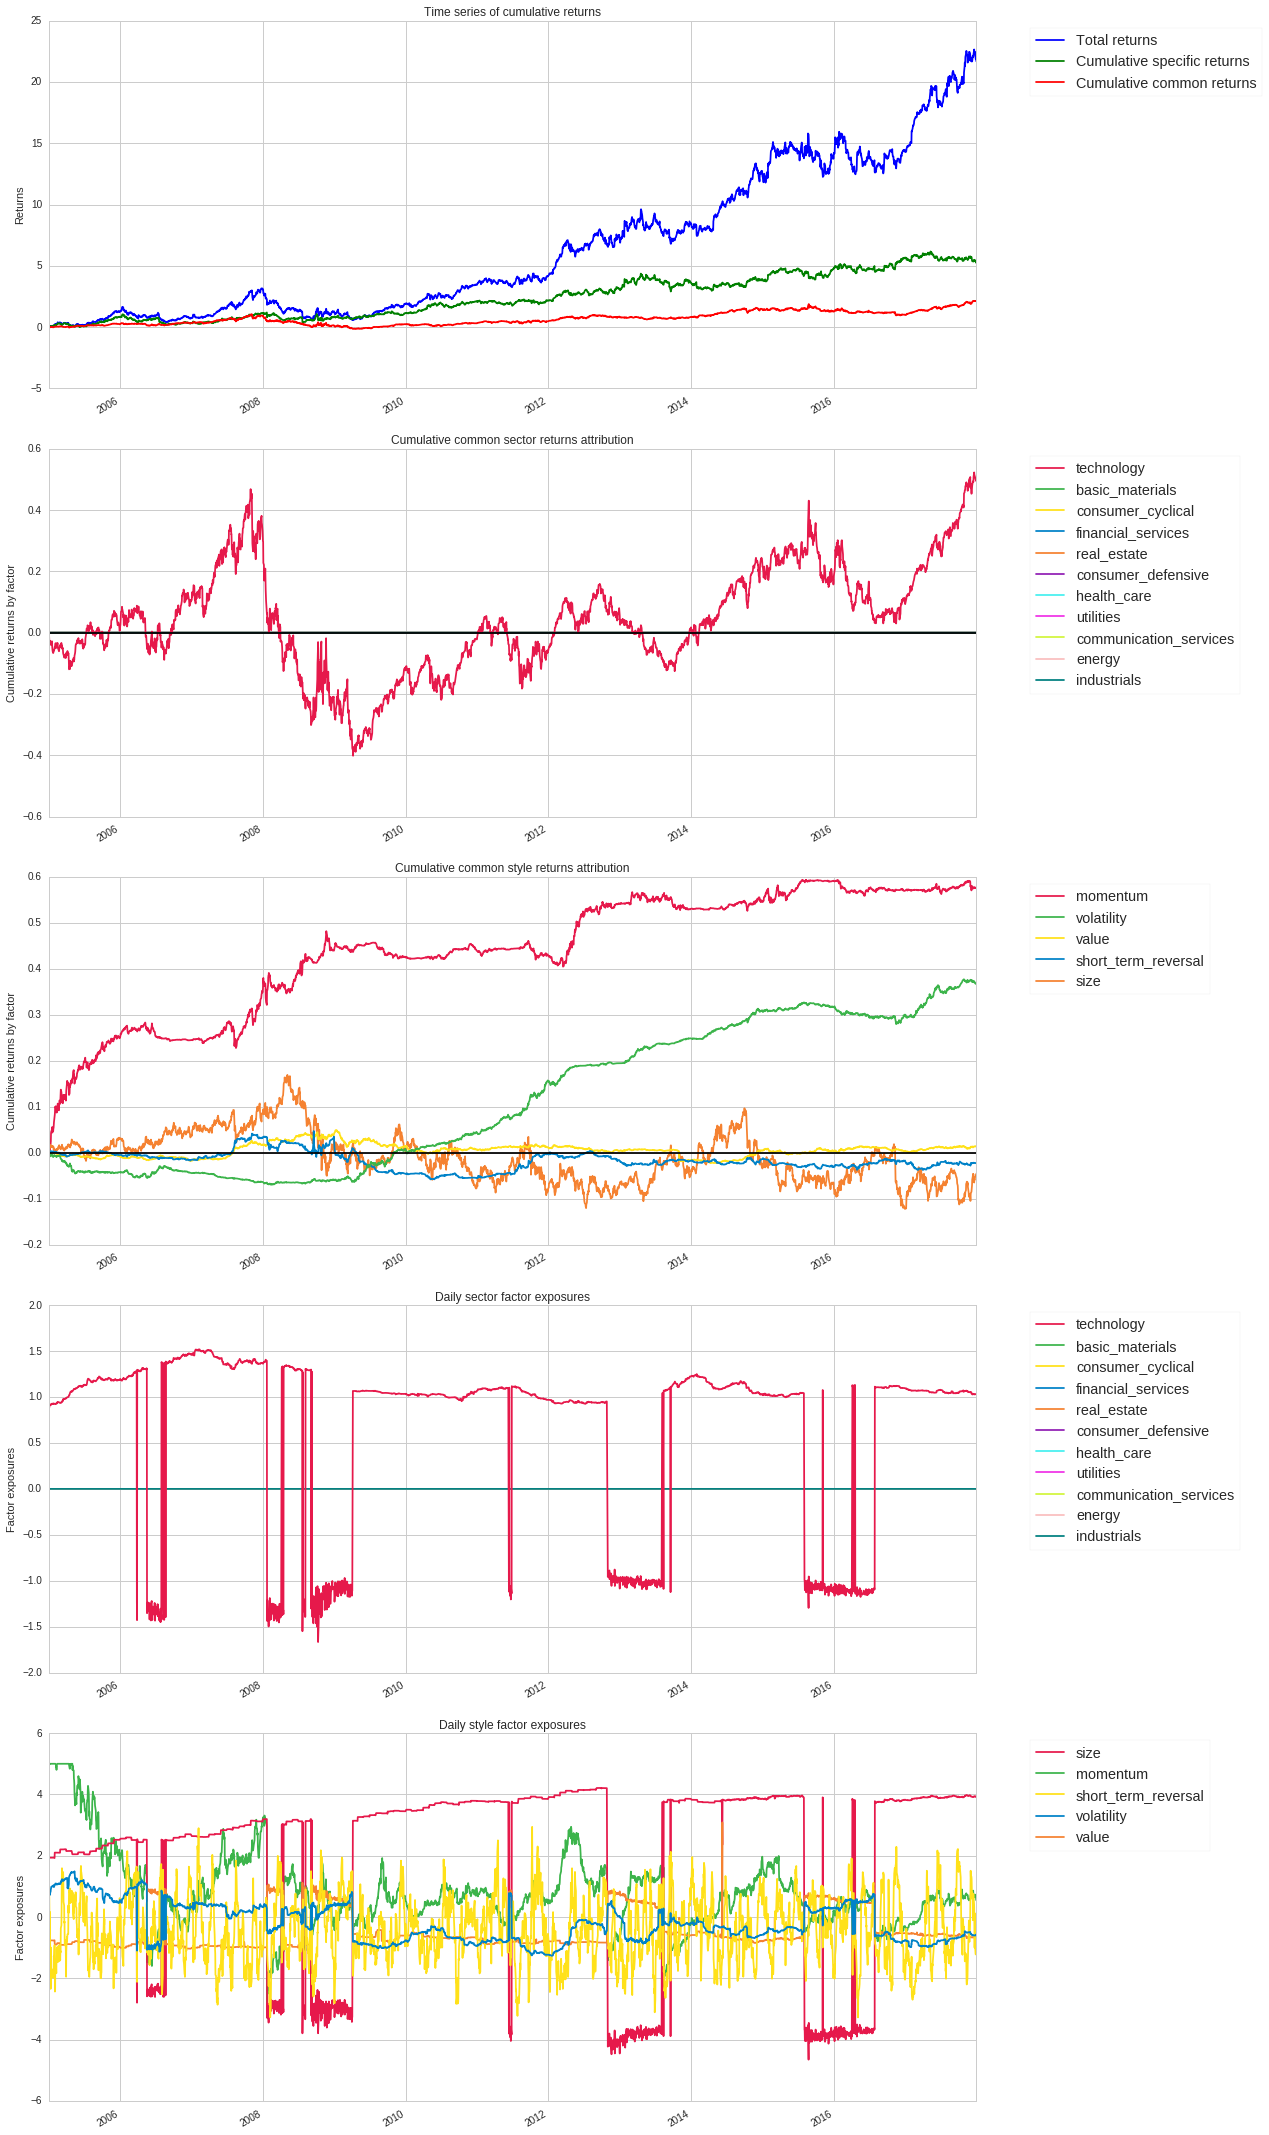

In [1]:
bt = get_backtest('5b9a7a6ffb9eed4384dce1e3')
bt.create_full_tear_sheet()

### AAPL MA 2-185 crossover from 2018-01-02 to 2018-09-13 (out of sample)
* Decent return, just as research suggested, algorithm works with AAPL

100% Time: 0:00:00|###########################################################|


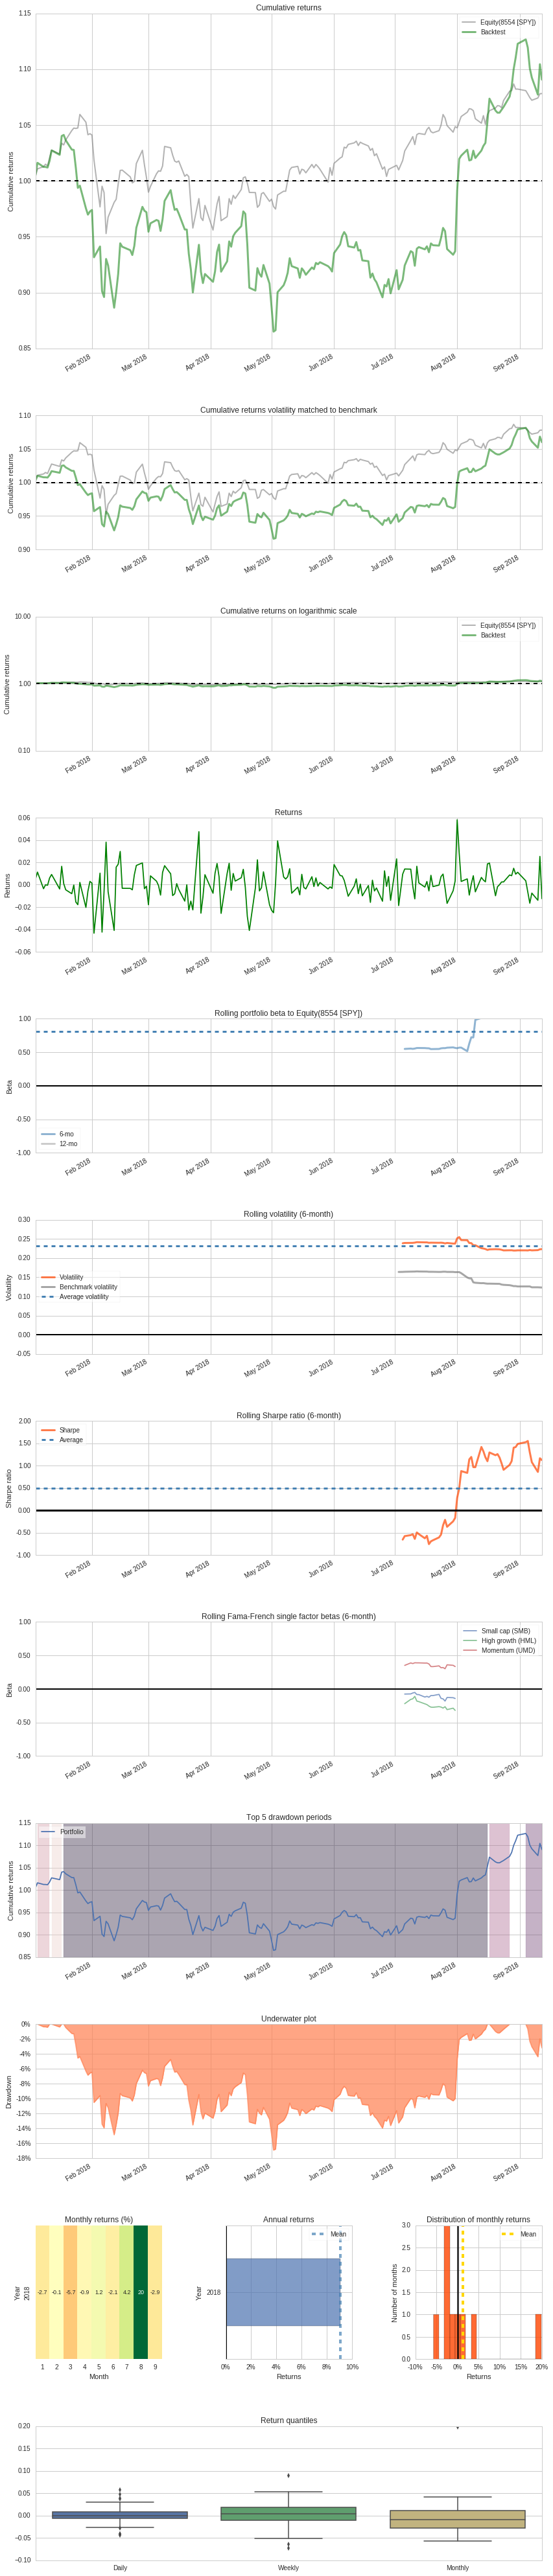

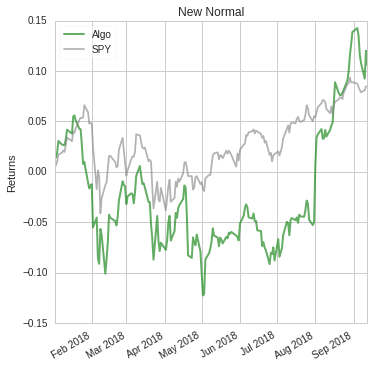

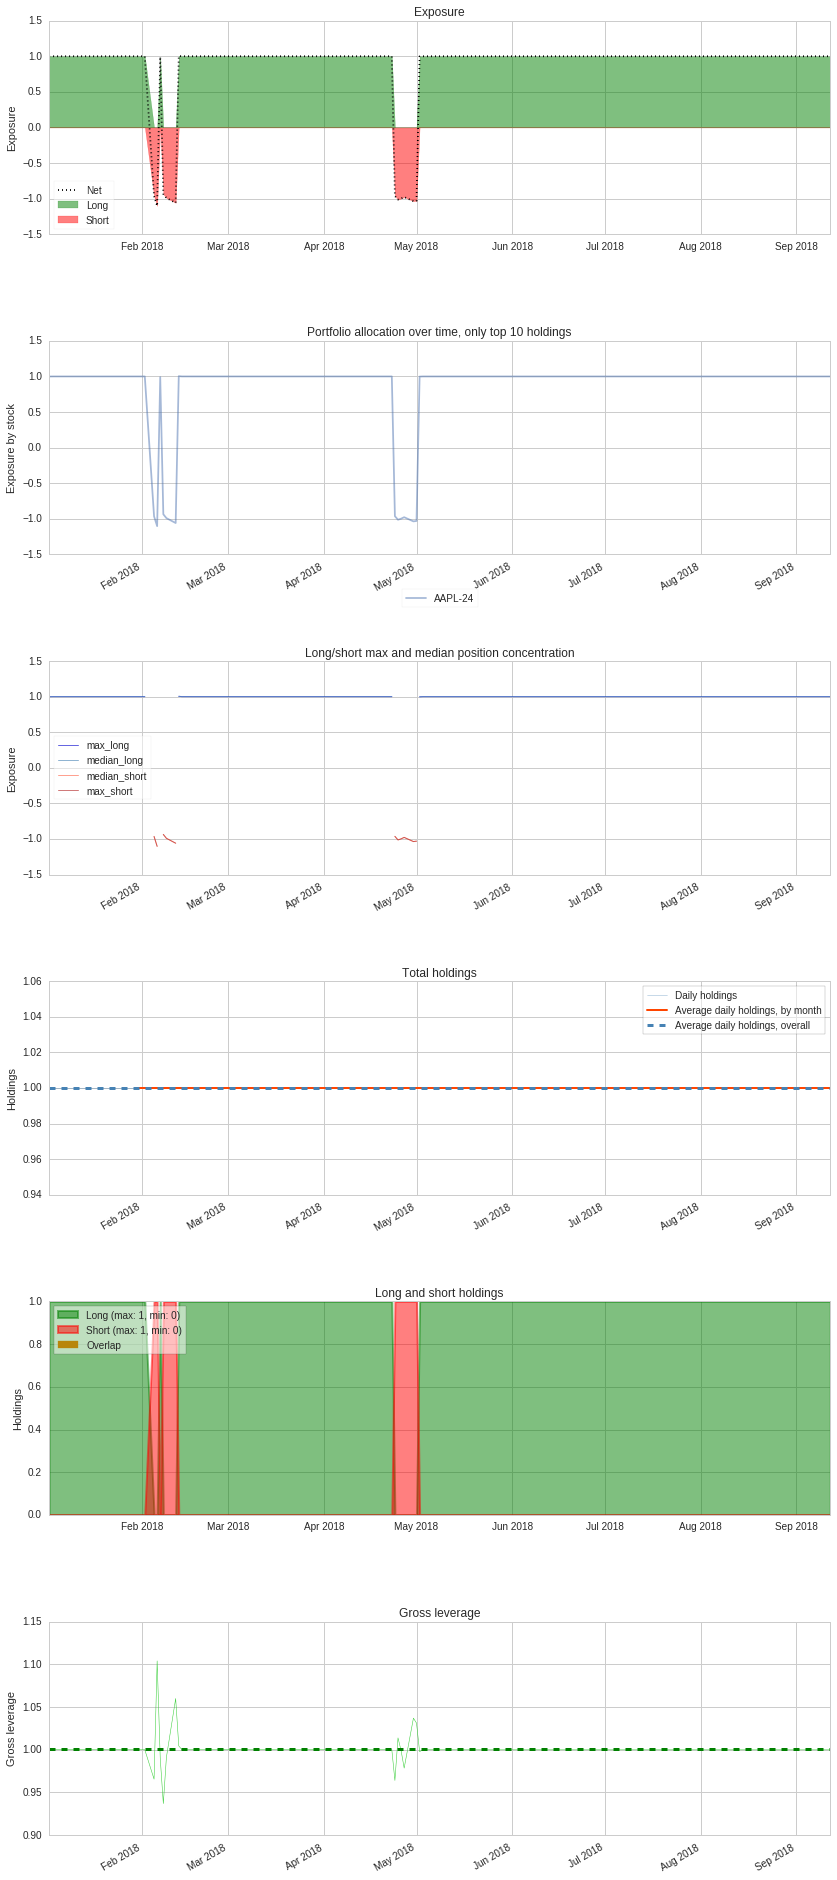

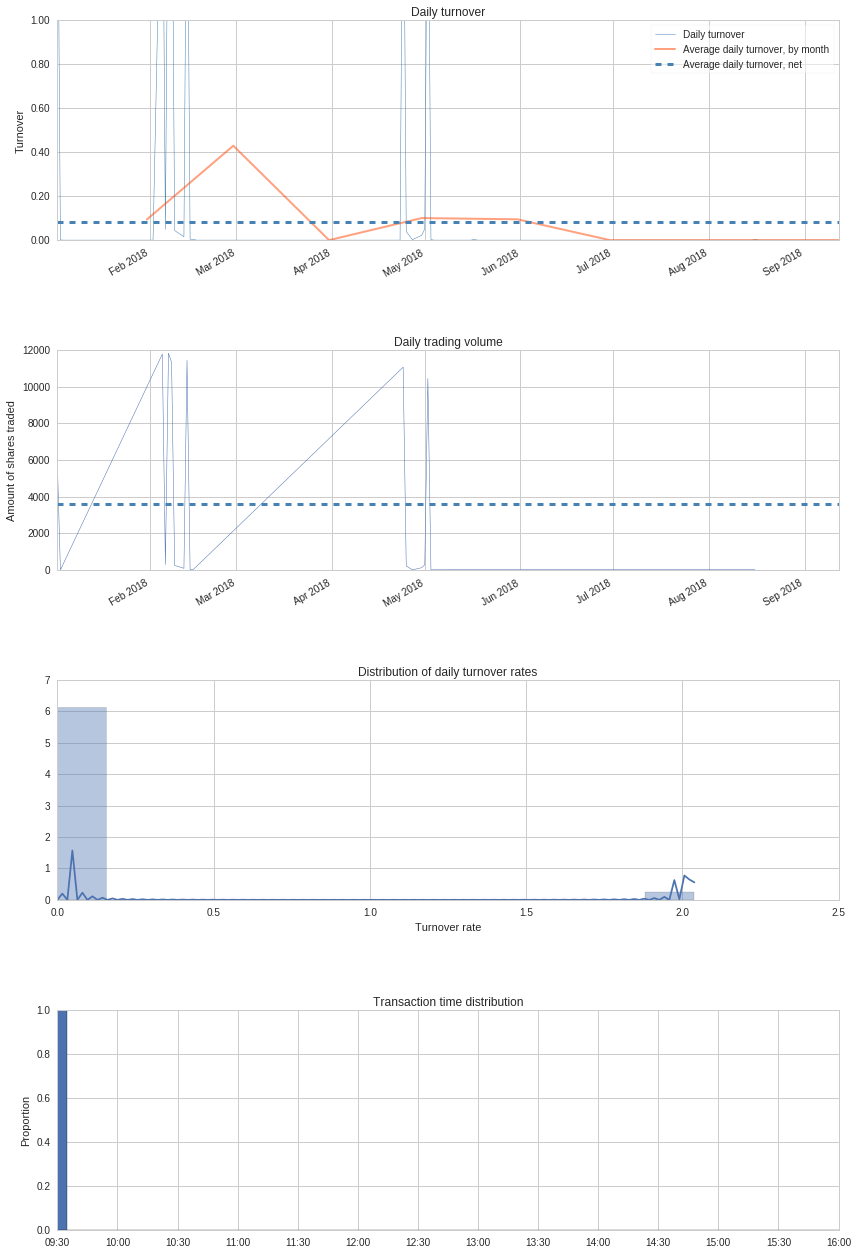

## Performance Relative to Common Risk Factors

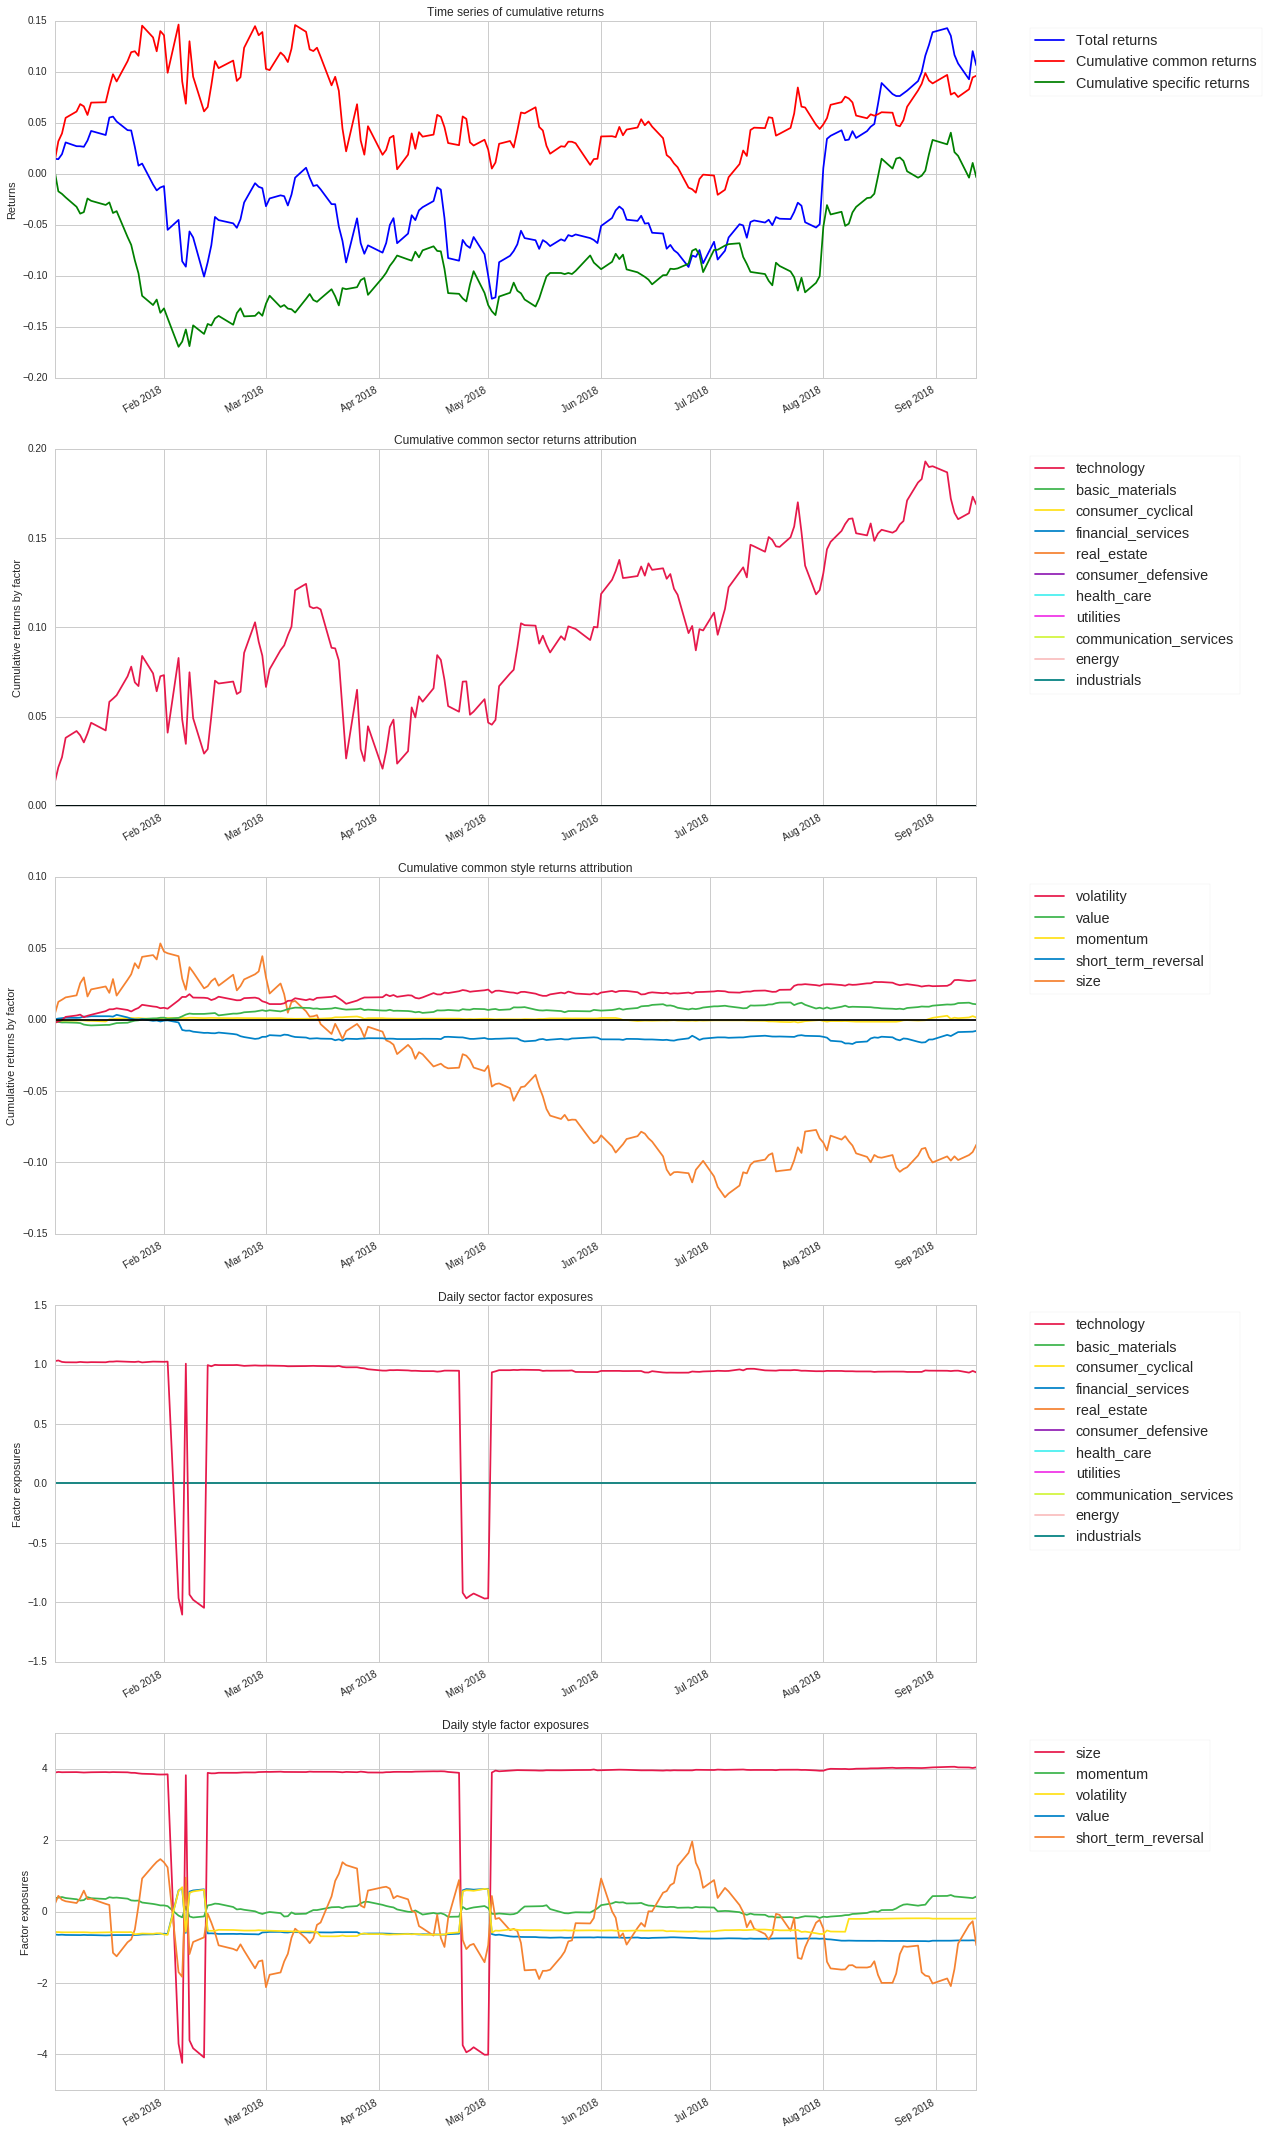

In [1]:
bt = get_backtest('5b9a85c27a0f3943e91b5531')
bt.create_full_tear_sheet()

### MSFT MA 2-185 crossover from 2002-10-18 to 2018-09-13
* Terrible return, just as research suggested, algorithm does not work across assets

100% Time: 0:00:04|###########################################################|


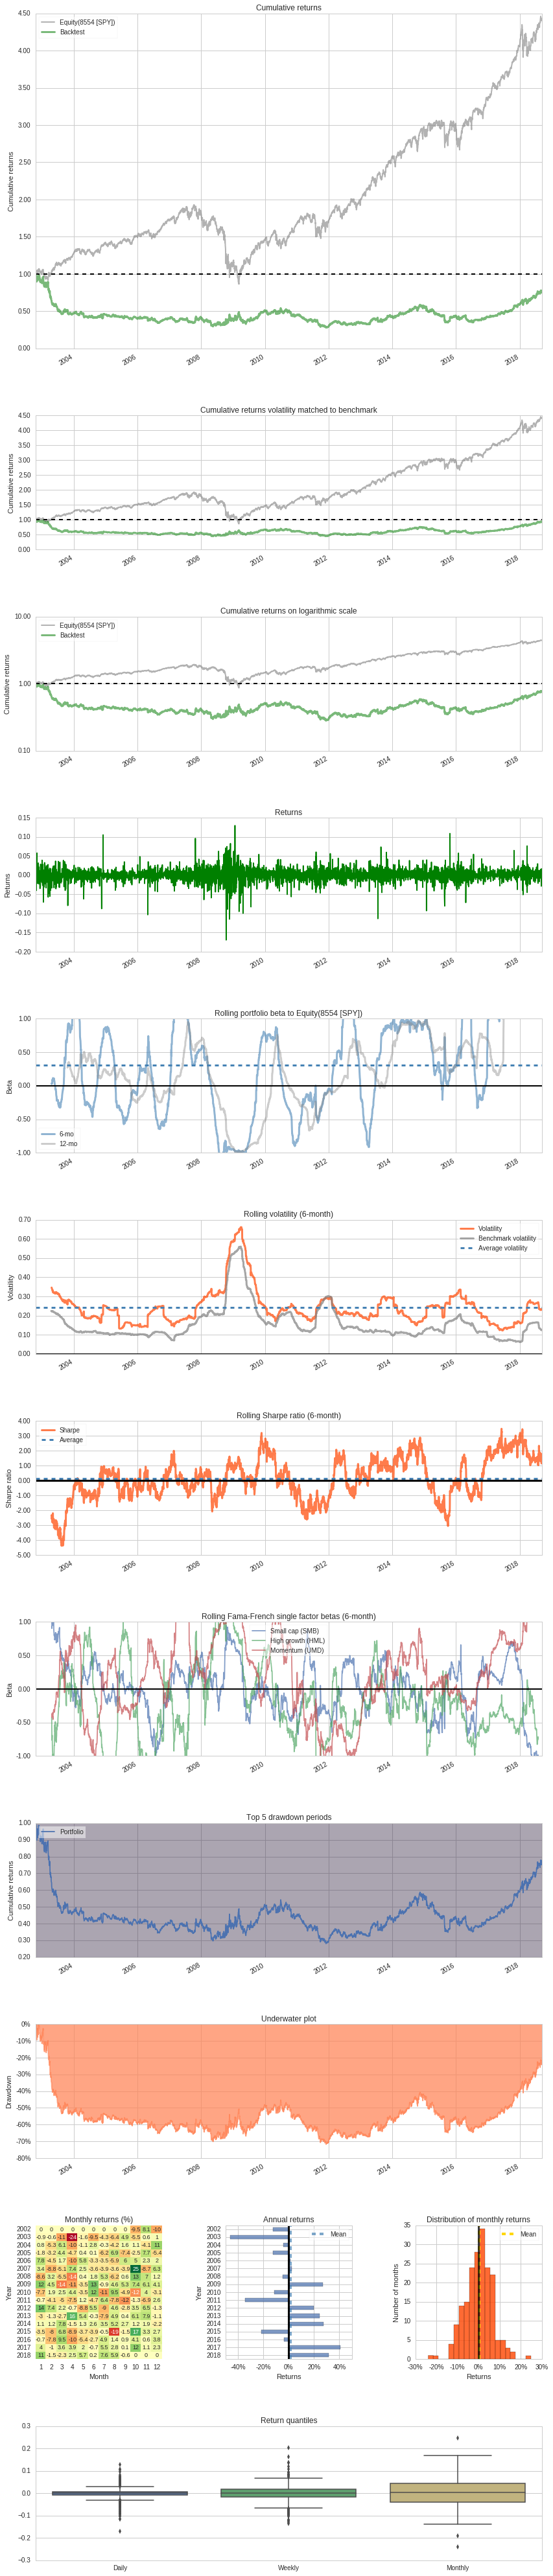

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


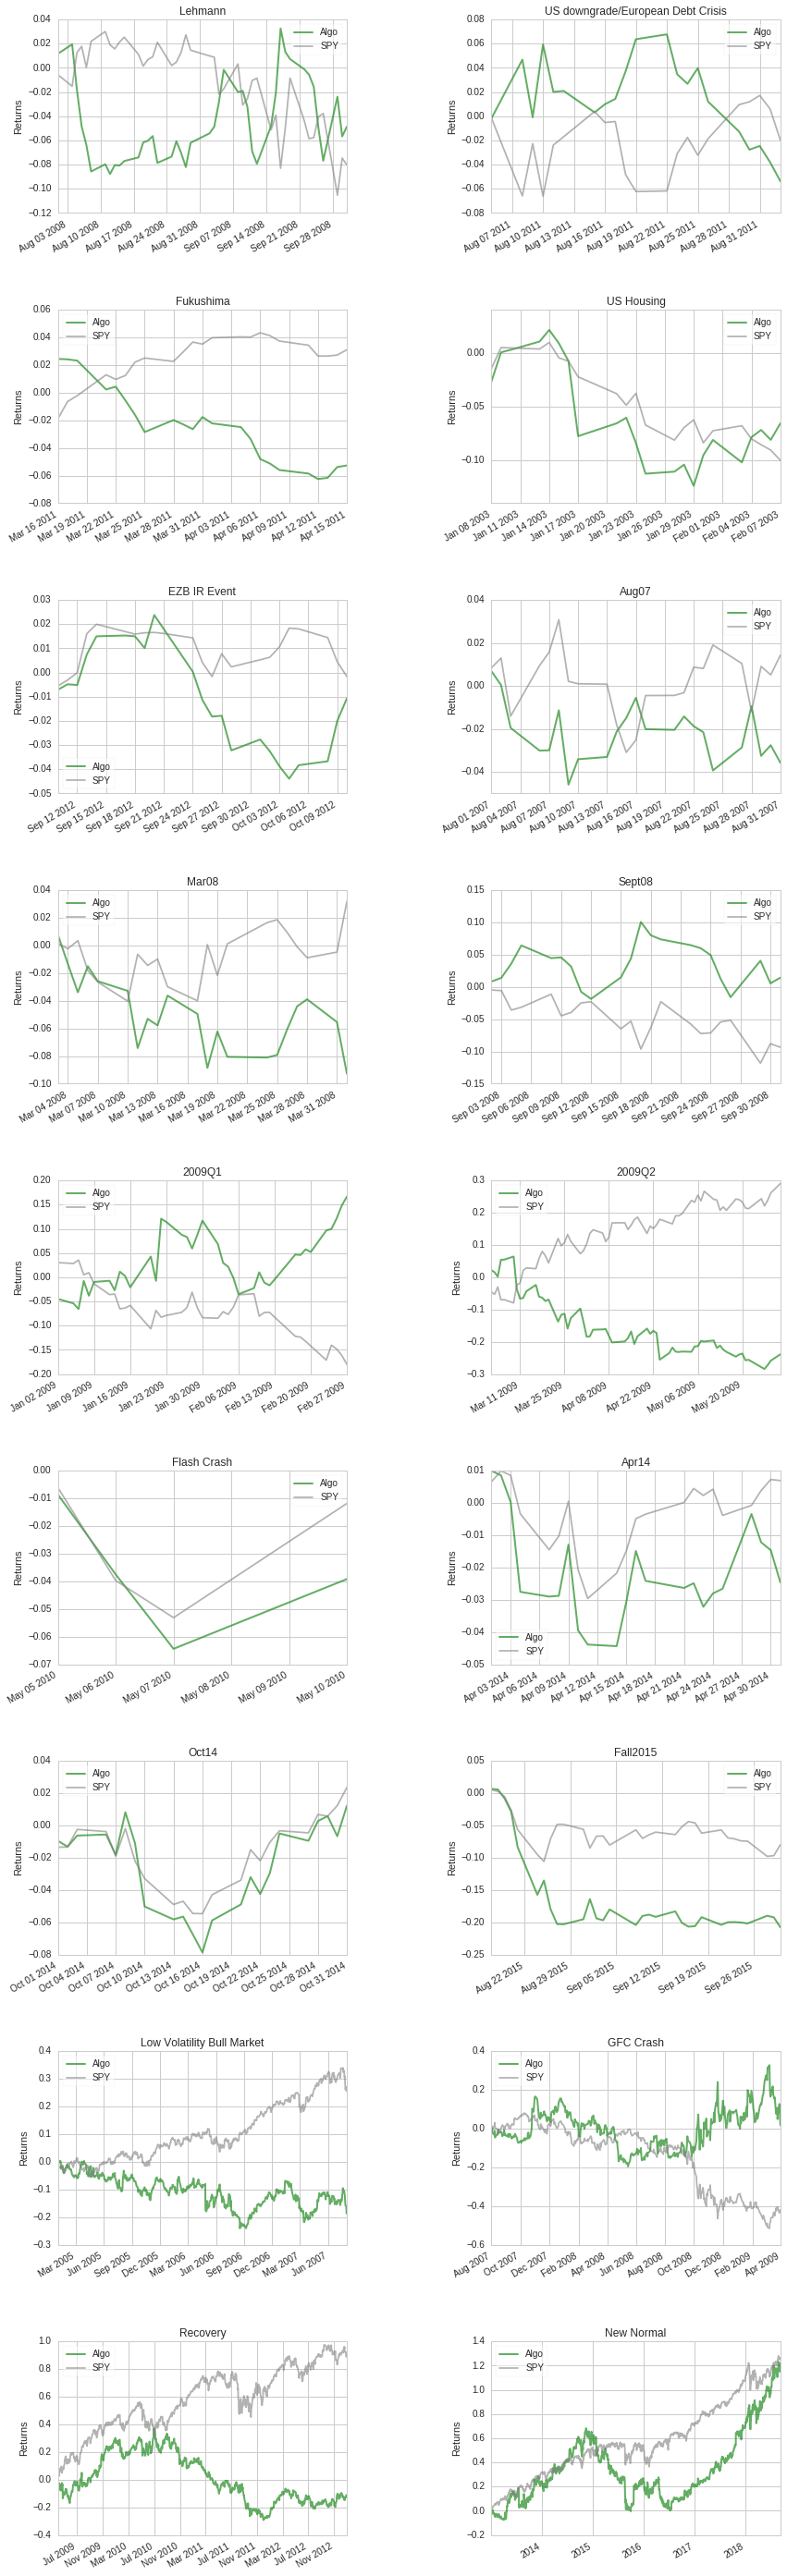

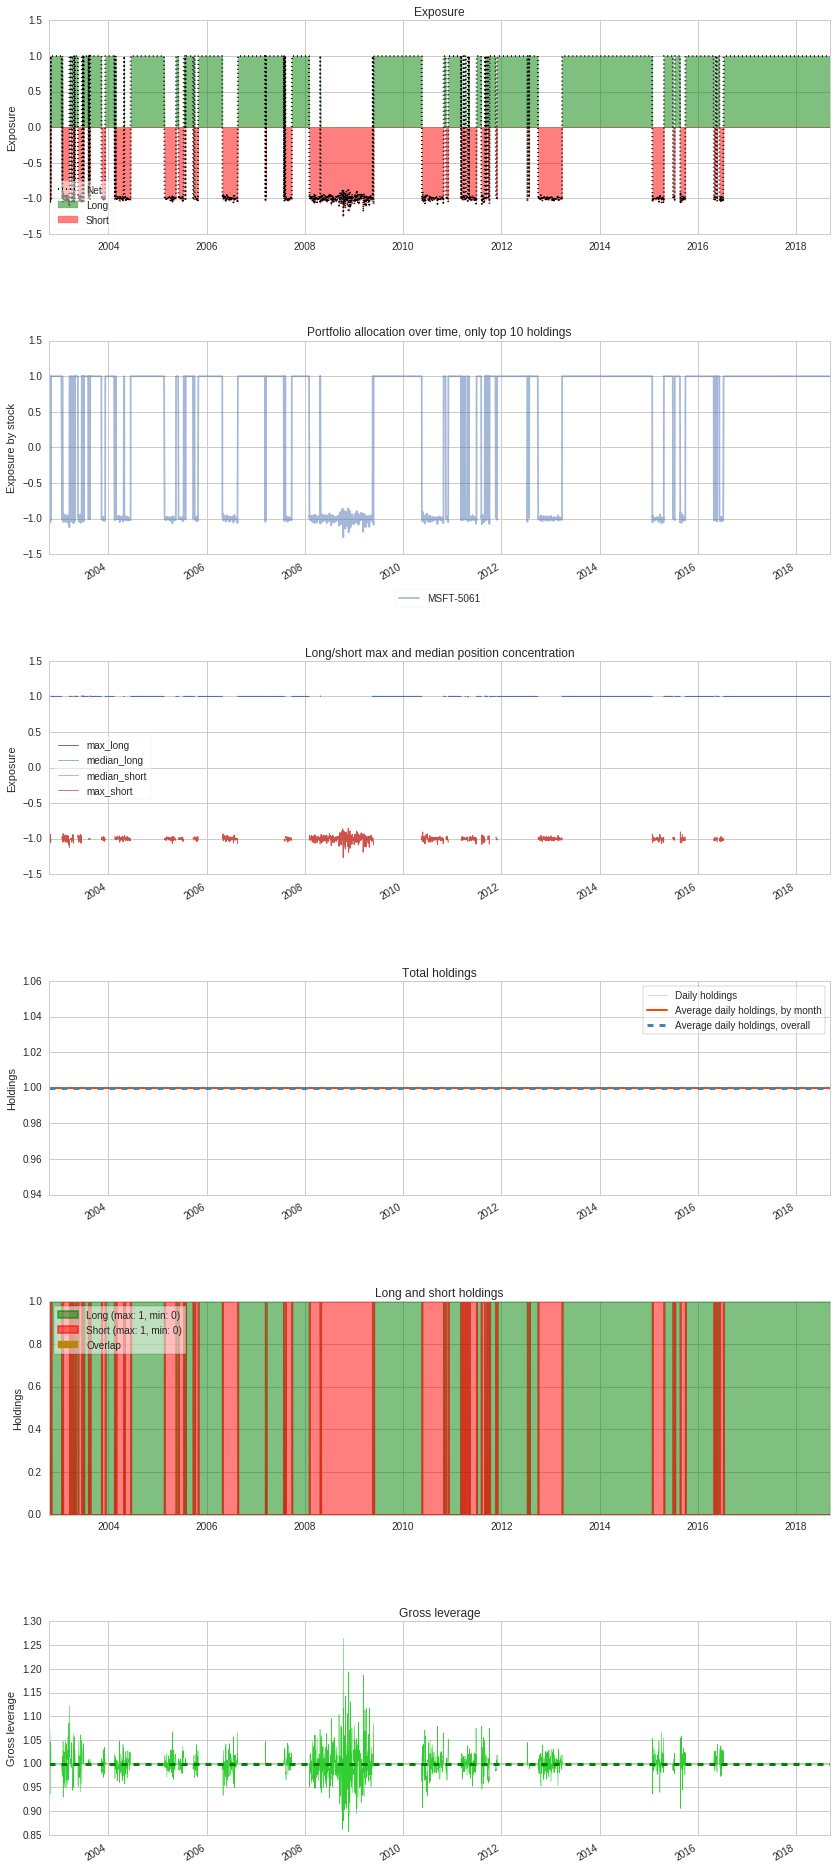

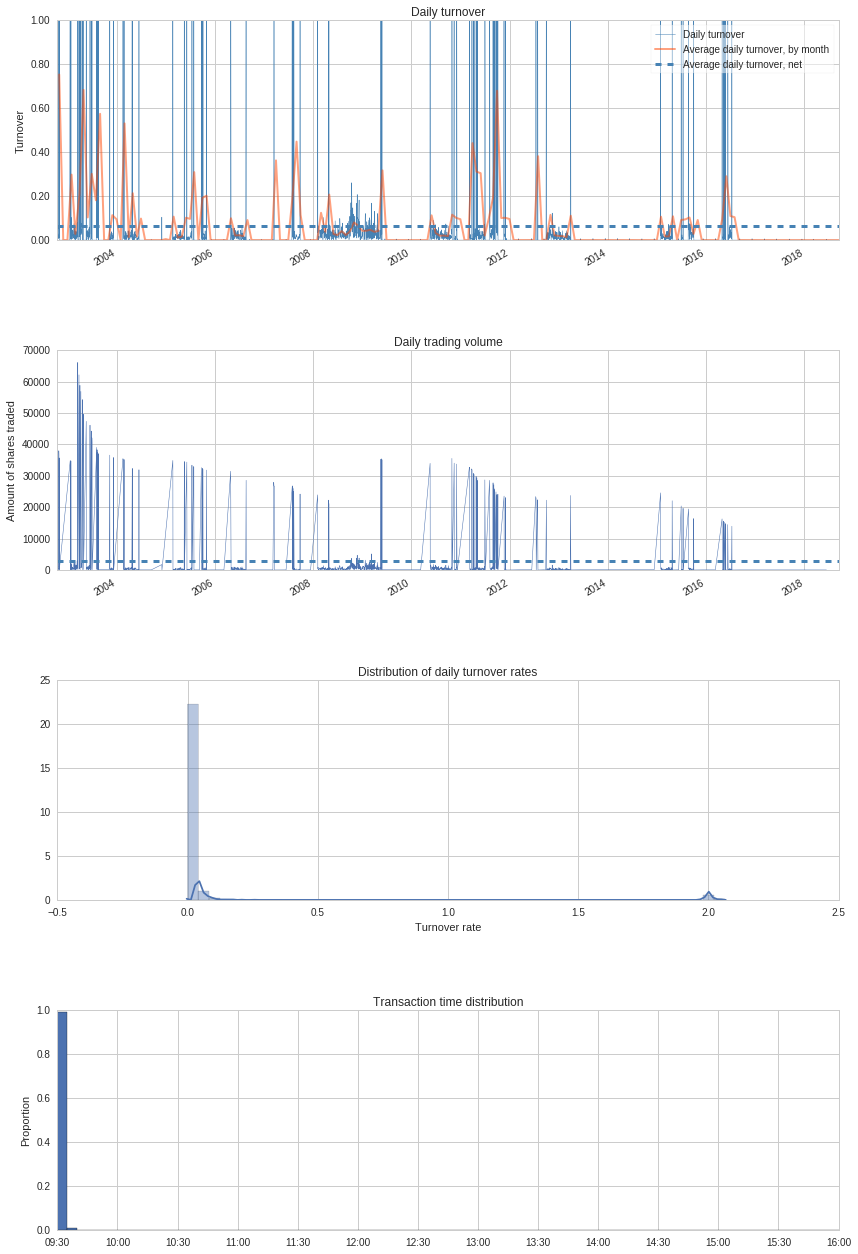

/usr/local/lib/python2.7/dist-packages/pyfolio/perf_attrib.py:589: UserWarning: Could not find factor loadings for 556 dates: (first missing is 2002-10-17 00:00:00+00:00, last missing is 2004-12-31 00:00:00+00:00). Truncating date range for performance attribution. 
  warnings.warn(warning_msg)


## Performance Relative to Common Risk Factors

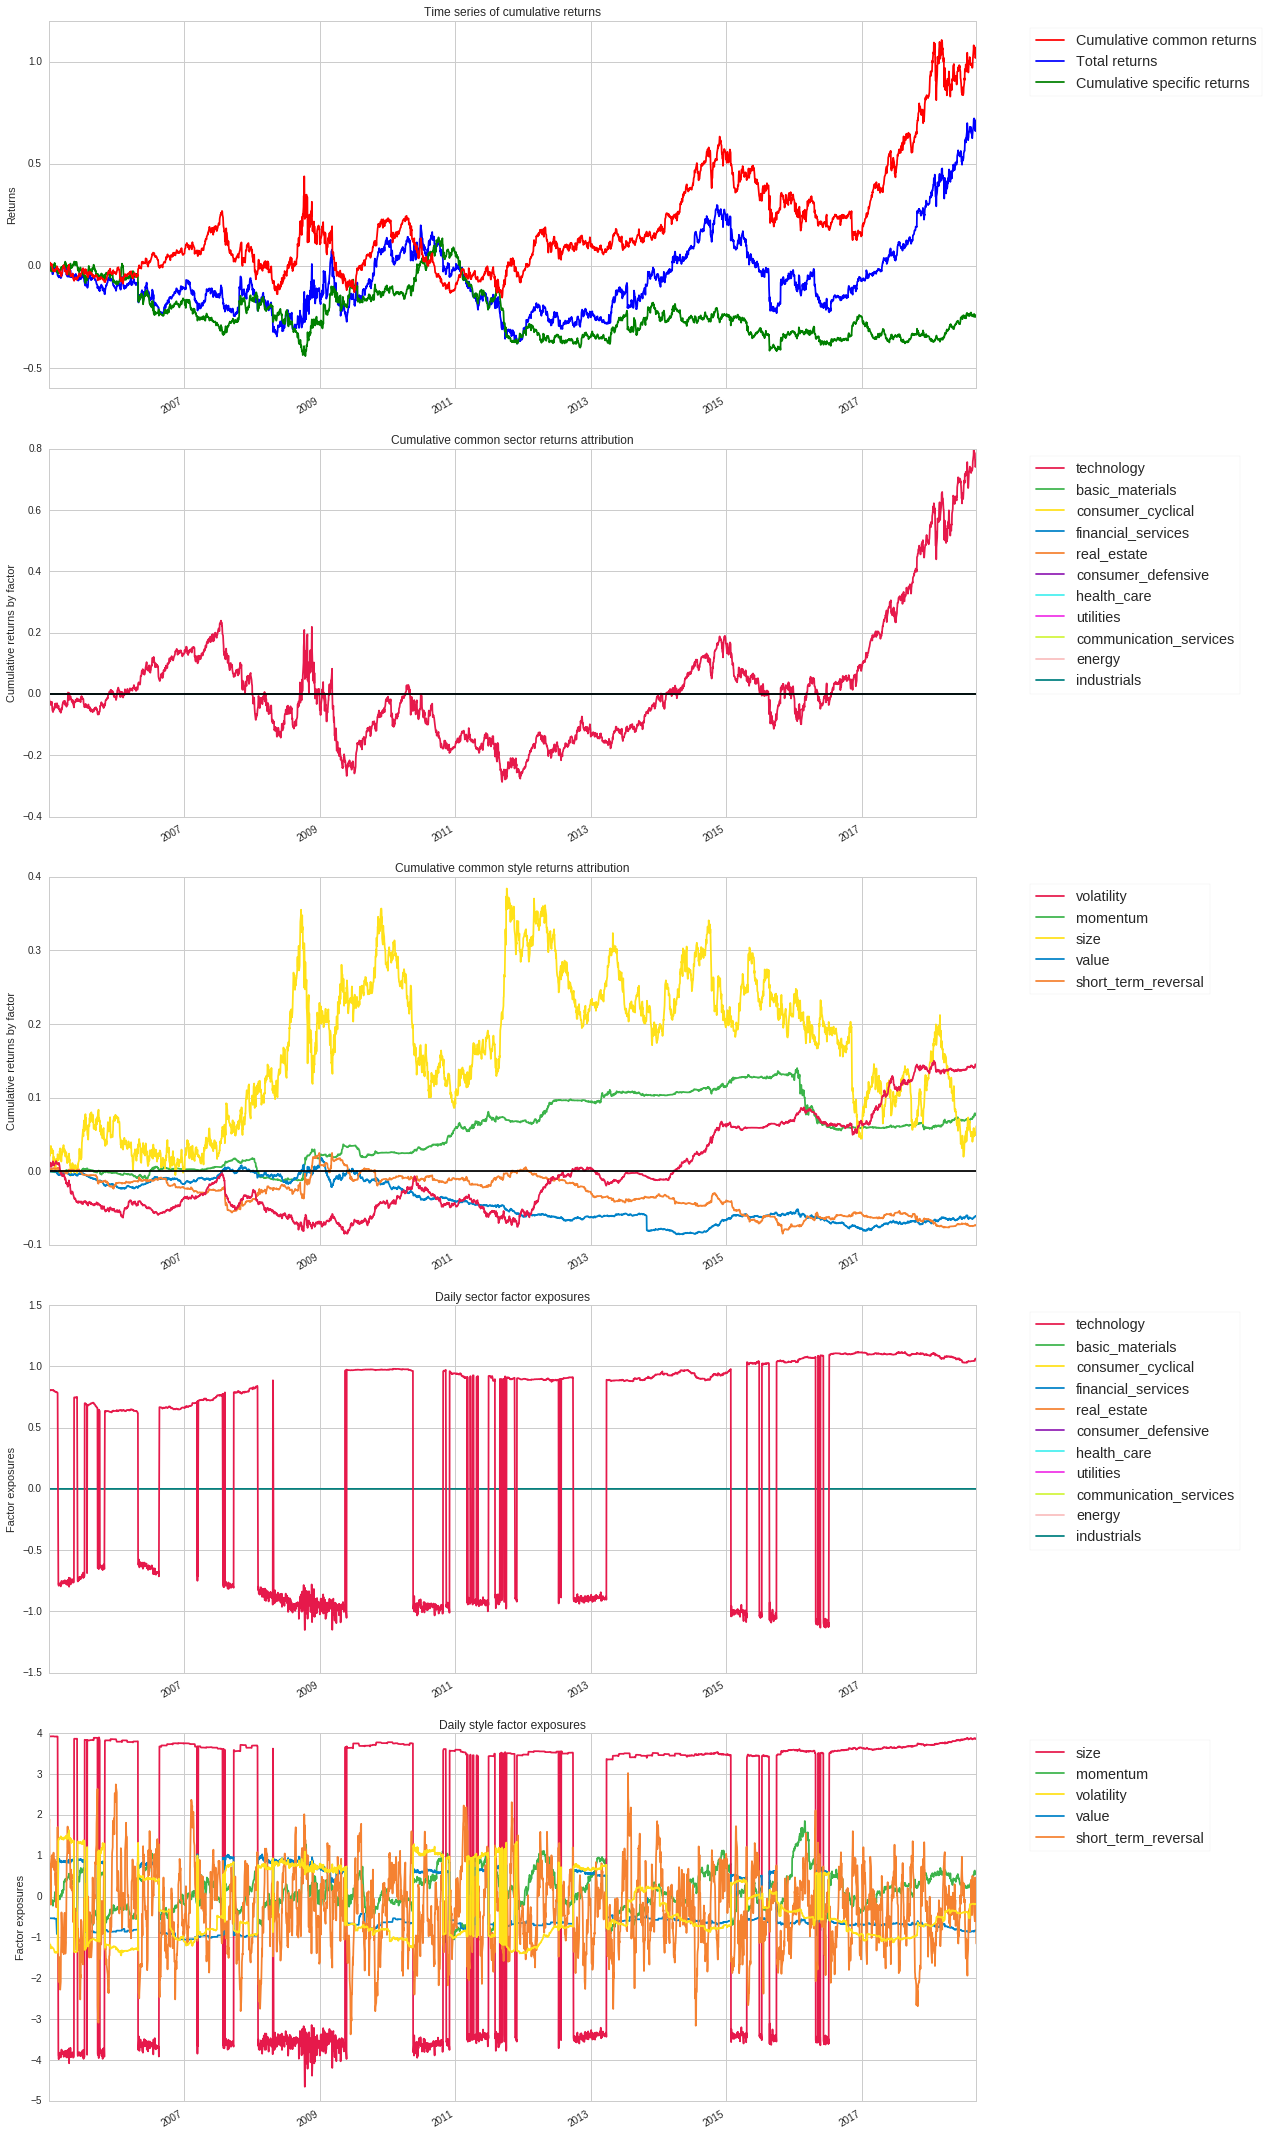

In [1]:
bt = get_backtest('5b9a879bf82a004426e12378')
bt.create_full_tear_sheet()